In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as datetime
import tensorflow as tf



In [2]:
# Load the .npz file
loaded_data = np.load('../datasets/windows.npz', allow_pickle=True)

# Convert the loaded data back to a dictionary of lists of NumPy arrays, excluding 'column_names'
windows = {label: list(arrays) for label, arrays in loaded_data.items() if label != 'column_names'}


for label, windows_list in windows.items():
    print(f"Label: {label}, Number of windows: {len(windows_list)}")

# Extract the column names
column_names = loaded_data['column_names']

# Convert the loaded data back to a dictionary of lists of DataFrames, using the column names
windows_df = {label: [pd.DataFrame(array, columns=column_names) for array in arrays_list] 
              for label, arrays_list in loaded_data.items() if label != 'column_names'}

# Loop through windows_df and set 'Datetime' as the index
for label, windows_list in windows_df.items():
    for i, window in enumerate(windows_list):
        # Convert 'Datetime' to a datetime object
        window['Datetime'] = pd.to_datetime(window['Datetime'])

        # Set 'Datetime' as the index
        windows_df[label][i] = window.set_index('Datetime')

Label: Chen, Number of windows: 12
Label: Song, Number of windows: 13


In [3]:
# Print the shape of each DataFrame in the windows dictionary
for label, windows_list in windows.items():
    print(f"Label: {label}")
    for i, window in enumerate(windows_list):
        print(f"Window {i}: {window.shape}")

Label: Chen
Window 0: (76, 10)
Window 1: (76, 10)
Window 2: (76, 10)
Window 3: (76, 10)
Window 4: (76, 10)
Window 5: (76, 10)
Window 6: (76, 10)
Window 7: (76, 10)
Window 8: (76, 10)
Window 9: (76, 10)
Window 10: (76, 10)
Window 11: (76, 10)
Label: Song
Window 0: (76, 10)
Window 1: (76, 10)
Window 2: (76, 10)
Window 3: (76, 10)
Window 4: (76, 10)
Window 5: (76, 10)
Window 6: (76, 10)
Window 7: (76, 10)
Window 8: (76, 10)
Window 9: (76, 10)
Window 10: (76, 10)
Window 11: (76, 10)
Window 12: (76, 10)


In [4]:
windows_df['Song'][0].head()

,co2,tempF,rhumid,atmpr,door1,door2,hvac,subject_count,lecturer
Datetime,,,,,,,,,
2024-03-14 12:15:00,773.0,74.5,37.0,1018.1,1,1,0,3.0,1
2024-03-14 12:16:00,770.0,74.4,37.0,1018.1,1,1,0,3.0,1
2024-03-14 12:17:00,786.0,74.4,36.0,1018.1,1,1,0,3.0,1
2024-03-14 12:18:00,798.0,74.2,36.0,1018.0,1,1,0,3.0,1
2024-03-14 12:19:00,824.0,74.1,36.0,1018.1,1,1,0,3.0,1


In [5]:
windows['Song'][0][:5]

array([[Timestamp('2024-03-14 12:15:00'), 773.0, 74.5, 37.0, 1018.1, 1,
        1, 0, 3.0, 1],
       [Timestamp('2024-03-14 12:16:00'), 770.0, 74.4, 37.0, 1018.1, 1,
        1, 0, 3.0, 1],
       [Timestamp('2024-03-14 12:17:00'), 786.0, 74.4, 36.0, 1018.1, 1,
        1, 0, 3.0, 1],
       [Timestamp('2024-03-14 12:18:00'), 798.0, 74.2, 36.0, 1018.0, 1,
        1, 0, 3.0, 1],
       [Timestamp('2024-03-14 12:19:00'), 824.0, 74.1, 36.0, 1018.1, 1,
        1, 0, 3.0, 1]], dtype=object)

## Numpy Array

In [6]:
# Initialize a list to store the 3D arrays and labels
X_list = []
y_list = []

for label, windows_list in windows.items():
    for window in windows_list:
        # Convert each DataFrame to a NumPy array and append to the list
        X_list.append(window)
        # Append the corresponding label to the label list
        y_list.append(label)

# Convert the list of 3D arrays to a single 3D array (tensor)
X = np.array(X_list)

# Convert the label list to a NumPy array
y = np.array(y_list)

# Print the shapes of the resulting arrays
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (25, 76, 10)
Shape of y: (25,)


Note that `y` is our classifer, in this case it classifies lectures in `X` as `0` for `Song` or `1` for `Chen`. So if we take $n$ slices from each lecture intervals in each lecture $X_i \in X$ to subsets $S_j \in S$ such that $U_{j=0}^{n} S_j = X_i$, we will have to ensure labels from `y` are assigned accordingly.

In [7]:
def find_divisors(n):
    divisors = [i for i in range(1, n + 1) if n % i == 0]
    return divisors

# Find divisors of 76
divisors_of_76 = find_divisors(76)
print("Divisors of 76:", divisors_of_76)

Divisors of 76: [1, 2, 4, 19, 38, 76]


In [8]:
import numpy as np

import numpy as np

# Assuming X is your original array with shape (25, 76, 10)
T = X.copy()

# Verify that the second dimension is divisible by 2
if T.shape[1] % 4 != 0:
    raise ValueError("The number of records in each layer must be divisible by 2")

# Reshape T directly to the new shape
# We reshape to (total number of new layers, new number of records per layer, number of features)
# Total number of new layers = original layers * 2 because we split each layer into 2
# New number of records per layer = original number of records per layer / 2
new_layers = T.shape[0] * 4
new_records_per_layer = T.shape[1] // 4
T = T.reshape(new_layers, new_records_per_layer, T.shape[2])

# Duplicate each element in y to match the new layer count
y = np.repeat(y, 4)

print("New shape of T:", T.shape)
print("New shape of y:", y.shape)


New shape of T: (100, 19, 10)
New shape of y: (100,)


In [9]:
# Drop the first and the last columns from the 3D array X
T = T[:, :, 1:-2]

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


T = T.astype(np.float64)
# Encode labels: 'Song' as 1, 'Chen' as 0
y = np.array([1 if label == 'Song' else 0 for label in y])
# Scale the features using StandardScaler

# Reshape X to 2D array
T_2d = T.reshape(-1, T.shape[-1])

# Scale the features using StandardScaler
scaler = StandardScaler()
T_scaled = scaler.fit_transform(T_2d)

# Reshape X_scaled back to 3D array
T_scaled_3d = T_scaled.reshape(T.shape[0], T.shape[1], T.shape[2])

# Split into training and test/validation sets
T_train, T_test, y_train, y_test = train_test_split(T_scaled_3d, y, test_size=20, random_state=42, stratify=y)

print("X_train shape:", T_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", T_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (80, 19, 7)
y_train shape: (80,)
X_test shape: (20, 19, 7)
y_test shape: (20,)


In [11]:
import tensorflow as tf
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=[19,7]))
model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='softmax'))

In [12]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='sgd',
              metrics=['accuracy'])

history = model.fit(T_train, y_train, epochs=25, validation_data=(T_test, y_test))


Epoch 1/25


3/3 [==============================] - 0s 62ms/step - loss: 3.6651 - accuracy: 0.0125 - val_loss: 3.1935 - val_accuracy: 0.1500
Epoch 2/25
3/3 [==============================] - 0s 10ms/step - loss: 3.2900 - accuracy: 0.0750 - val_loss: 2.8310 - val_accuracy: 0.3000
Epoch 3/25
3/3 [==============================] - 0s 11ms/step - loss: 2.9314 - accuracy: 0.1875 - val_loss: 2.5039 - val_accuracy: 0.4000
Epoch 4/25
3/3 [==============================] - 0s 10ms/step - loss: 2.5892 - accuracy: 0.3375 - val_loss: 2.2105 - val_accuracy: 0.4500
Epoch 5/25
3/3 [==============================] - 0s 11ms/step - loss: 2.2726 - accuracy: 0.4625 - val_loss: 1.9507 - val_accuracy: 0.5000
Epoch 6/25
3/3 [==============================] - 0s 11ms/step - loss: 1.9752 - accuracy: 0.6500 - val_loss: 1.7250 - val_accuracy: 0.7000
Epoch 7/25
3/3 [==============================] - 0s 10ms/step - loss: 1.7244 - accuracy: 0.7250 - val_loss: 1.5302 - val_accuracy: 0.7000
Epoch 8/25
3/3 [========

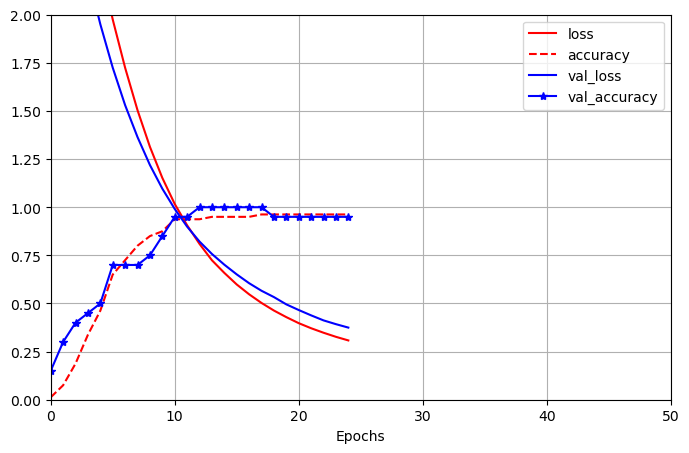

In [13]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5),
    xlim=[0, 50], ylim=[0, 2], xlabel='Epochs', grid=True,
    style=['r', 'r--', 'b', 'b-*'])
plt.show()

In [14]:
model.evaluate(T_test, y_test)

1/1 [==============================] - 0s 15ms/step - loss: 0.3747 - accuracy: 0.9500


[0.3746911585330963, 0.949999988079071]

In [15]:
y_proba = model.predict(T_test)
y_proba.round(2)
y_pred = np.argmax(y_proba, axis=1)
y_pred, y_test

1/1 [==============================] - 0s 50ms/step


(array([0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1],
       dtype=int64),
 array([1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1]))

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_classification(y_true, y_pred, average='macro'):
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    f1 = f1_score(y_true, y_pred, average=average)
    
    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    
    # Return metrics as a dictionary
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1}

# Example usage (ensure y_test and y_pred are defined appropriately)
metrics = evaluate_classification(y_test, y_pred)


Accuracy: 0.9500
Precision: 0.9545
Recall: 0.9500
F1-score: 0.9499


# Tensor Array

# Preparing RNN Sequenceing for prediction

In [17]:
M = X.copy()
print("Shape of our sequenced samples M:", M.shape)

# Assuming M is already defined and has shape (25, 76, 20)
# Set the seed for reproducibility and split the data
M_train, M_test = train_test_split(M, test_size=0.2, random_state=42)

# Print shapes to confirm the setup
print("M_train shape:", M_train.shape)  # Expected to have around 80% of the data
print("M_test shape:", M_test.shape)    # Expected to have around 20% of the data

Shape of our sequenced samples M: (25, 76, 10)
M_train shape: (20, 76, 10)
M_test shape: (5, 76, 10)


In [18]:
# Calculating the split index for 90% of the time steps
split_index = int(0.8 * 19)  

# Splitting the training data
X_train = T_train[:, :split_index, :]
y_train = T_train[:, split_index:, :]

# Splitting the testing data
X_test = T_test[:, :split_index, :]
y_test = T_test[:, split_index:, :]

# Print shapes to confirm the setup
print("X_train shape:", X_train.shape)  
print("y_train shape:", y_train.shape)  
print("X_test shape:", X_test.shape)    
print("y_test shape:", y_test.shape)    



X_train shape: (80, 15, 7)
y_train shape: (80, 4, 7)
X_test shape: (20, 15, 7)
y_test shape: (20, 4, 7)


In [19]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

# Print shapes for debugging
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Set random seed for reproducibility
tf.random.set_seed(42)

# # Define the model
# model = tf.keras.Sequential([
#     tf.keras.layers.SimpleRNN(32, activation='relu', input_shape=(15, 7)),  # Input layer
#     tf.keras.layers.Dense(16, activation='relu'),  # Hidden layer
#     tf.keras.layers.Dense(4 * 7, activation=None)  # Output layer to predict 16 timesteps, each with 20 features
# ])
# model.add(tf.keras.layers.Reshape((4, 7)))  # Reshape output to match (16, 20)

# Define the LSTM model with dropout
model = tf.keras.Sequential([
    # Adding dropout and recurrent dropout to the LSTM layer
    tf.keras.layers.LSTM(32, activation='relu', input_shape=(15, 7),
                         dropout=0.2, recurrent_dropout=0.2),
    # Adding L2 regularization to the Dense layer
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    # Output layer to predict 8 timesteps, each with 20 features
    tf.keras.layers.Dense(4 * 7, activation=None)
])
model.add(tf.keras.layers.Reshape((4, 7)))  # Reshape output to match (8, 20)


# Define early stopping callback
early_stopping = EarlyStopping(monitor='mae', patience=50, restore_best_weights=True)

# Define optimizer
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

# Compile the model
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=2000, validation_data=(X_test, y_test), callbacks=[early_stopping])



X_train shape: (80, 15, 7)
y_train shape: (80, 4, 7)
X_test shape: (20, 15, 7)
y_test shape: (20, 4, 7)
Epoch 1/2000
3/3 [==============================] - 2s 116ms/step - loss: 1.1488 - mae: 0.8111 - val_loss: 1.5027 - val_mae: 0.9058
Epoch 2/2000
3/3 [==============================] - 0s 14ms/step - loss: 1.1474 - mae: 0.8101 - val_loss: 1.4997 - val_mae: 0.9049
Epoch 3/2000
3/3 [==============================] - 0s 13ms/step - loss: 1.1424 - mae: 0.8077 - val_loss: 1.4957 - val_mae: 0.9036
Epoch 4/2000
3/3 [==============================] - 0s 19ms/step - loss: 1.1346 - mae: 0.8053 - val_loss: 1.4910 - val_mae: 0.9020
Epoch 5/2000
3/3 [==============================] - 0s 16ms/step - loss: 1.1264 - mae: 0.8013 - val_loss: 1.4860 - val_mae: 0.9003
Epoch 6/2000
3/3 [==============================] - 0s 13ms/step - loss: 1.1205 - mae: 0.8000 - val_loss: 1.4809 - val_mae: 0.8986
Epoch 7/2000
3/3 [==============================] - 0s 14ms/step - loss: 1.1089 - mae: 0.7946 - val_loss: 1.4

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predictions on test set
y_pred = model.predict(X_test)

# Flatten the predictions and actual values for metric calculations
y_true_flat = y_test.reshape(-1)
y_pred_flat = y_pred.reshape(-1)

# Calculate metrics
test_mae = mean_absolute_error(y_true_flat, y_pred_flat)
test_rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
test_r2 = r2_score(y_true_flat, y_pred_flat)

# Print the metrics
print(f'Test MAE: {test_mae:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')
print(f'Test R-squared: {test_r2:.4f}')


# Extracting predictions for CO2 (assuming it's the first column in the output)
y_pred_co2 = y_pred[:, :, 0]  # Adjust the index if CO2 is not the first column
y_true_co2 = y_test[:, :, 0]

# Flatten the CO2 predictions and actual values
y_true_co2_flat = y_true_co2.reshape(-1)
y_pred_co2_flat = y_pred_co2.reshape(-1)

# Calculate metrics for CO2
test_mae_co2 = mean_absolute_error(y_true_co2_flat, y_pred_co2_flat)
test_rmse_co2 = np.sqrt(mean_squared_error(y_true_co2_flat, y_pred_co2_flat))
test_r2_co2 = r2_score(y_true_co2_flat, y_pred_co2_flat)

# Print the metrics for CO2
print(f'Test MAE for CO2: {test_mae_co2:.4f}')
print(f'Test RMSE for CO2: {test_rmse_co2:.4f}')
print(f'Test R-squared for CO2: {test_r2_co2:.4f}')


1/1 [==============================] - 0s 183ms/step
Test MAE: 0.3901
Test RMSE: 0.6735
Test R-squared: 0.6465
Test MAE for CO2: 0.5887
Test RMSE for CO2: 0.9495
Test R-squared for CO2: 0.5631


In [21]:
import numpy as np
from sklearn.metrics import r2_score

def calculate_r2_per_feature(y_true, y_pred):
    """
    Calculates the R-squared score for each feature across all timesteps.
    Args:
    y_true (numpy.ndarray): True values of the test set.
    y_pred (numpy.ndarray): Predicted values from the model.
    
    Returns:
    dict: A dictionary with feature indices as keys and R-squared scores as values.
    """
    r2_scores = {}
    for feature_index in range(y_true.shape[2]):  # Assuming the last dimension represents features
        y_true_feature = y_true[:, :, feature_index].reshape(-1)
        y_pred_feature = y_pred[:, :, feature_index].reshape(-1)
        r2_scores[feature_index] = r2_score(y_true_feature, y_pred_feature)
    return r2_scores

In [22]:
# Assuming y_test and y_pred are already defined and contain the test and predicted data respectively.
r2_scores = calculate_r2_per_feature(y_test, y_pred)
print("R-squared scores for each feature:", r2_scores)

R-squared scores for each feature: {0: 0.5631207410400711, 1: 0.49286709176845833, 2: 0.8821879560782109, 3: 0.8929307098455981, 4: 0.5245914859980021, 5: 0.9620197797356367, 6: 0.2504928371569689}


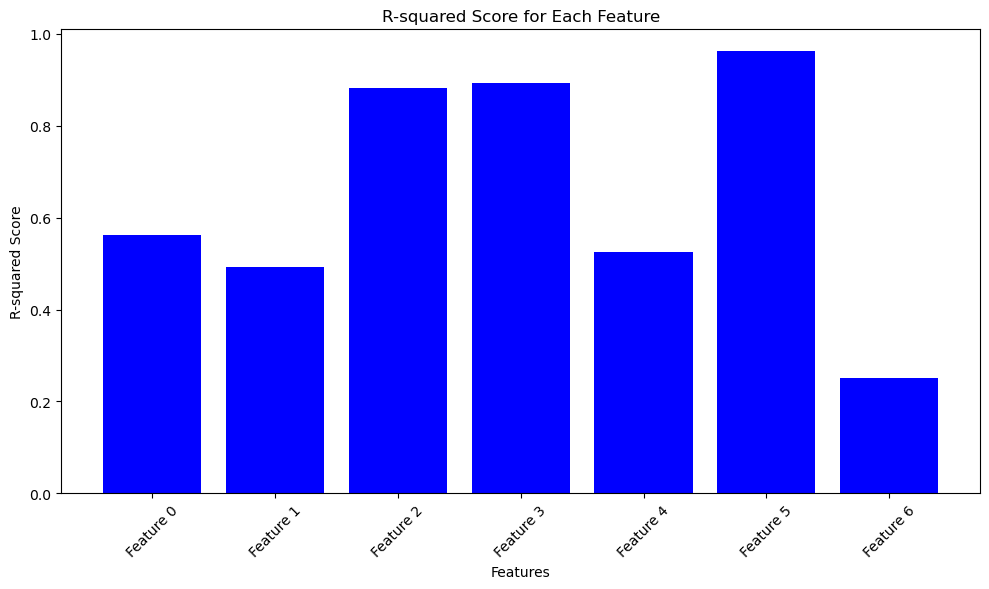

In [23]:
import matplotlib.pyplot as plt

# Extract feature names if available or use generic names
feature_names = ['Feature {}'.format(i) for i in range(y_test.shape[2])]  # Adjust or replace with actual names

# Extract R2 values and sort by value
r2_values = [r2_scores[i] for i in sorted(r2_scores)]

plt.figure(figsize=(10, 6))
plt.bar(feature_names, r2_values, color='blue')
plt.xlabel('Features')
plt.ylabel('R-squared Score')
plt.title('R-squared Score for Each Feature')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()